In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from PIL import Image
from sklearn import metrics
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
class Resnet50Encoder(nn.Module):

    def __init__(self, embedding_dim=512, weights=models.ResNet50_Weights.IMAGENET1K_V2):
        super().__init__()
        self.encoder = models.resnet50(weights=weights)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-1])
        self.fc = nn.Linear(2048, embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), x.size(1))
        x = self.fc(x)
        return x

In [3]:
class ImageTransformer(nn.Module):

    def __init__(
        self,
        image_encoder,
        d_model=512,
        nhead=8,
        dim_feedforward=2048,
        dropout=0.1,
        activation="relu",
        num_layers=6,
        num_classes=2
    ):
        super().__init__()
        self.d_model = d_model

        self.image_encoder = image_encoder

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,
            activation=activation, 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        batch_size, seq_len, im_chan, im_width, im_height = x.size()

        x = x.view(batch_size * seq_len, im_chan, im_width, im_height)
        x = self.image_encoder(x)

        x = x.view(batch_size, seq_len, self.d_model)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.transformer_encoder(x)

        x = self.fc(x[:, 0, :])
        return x

In [4]:
def image_to_numpy(image_path):
    image_pil = Image.open(image_path)
    image_np = np.array(image_pil, dtype=np.float32) / 255.0
    return image_np

In [5]:
class PatientImageDataset(Dataset):

    def __init__(self, 
        patient_path, 
        transform_function=None,
    ):
        super().__init__()
        self.patient_path = patient_path
        self.transform_function = transform_function

        images_path = []
        for image_path in os.listdir(patient_path):
            images_path.append(os.path.join(patient_path, image_path))

        self.images_path = images_path

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        image_path = self.images_path[index]
        image = image_to_numpy(image_path)
        if self.transform_function is not None:
            image = self.transform_function(image)
        return image

In [6]:
class PatientsDataset(Dataset):

    def __init__(
        self, 
        split_dir, 
        patients_ids,
        patients_labels
    ):
        super().__init__()
        self.split_dir = split_dir
        self.patients_ids = patients_ids
        self.patients_labels = patients_labels

    def __len__(self):
        return len(self.patients_ids)

    def __getitem__(self, index):
        patient_id = self.patients_ids[index]
        patient_label = self.patients_labels[index]
        patient_path = os.path.join(self.split_dir, patient_id)
        return {
            "id": patient_id, 
            "label": patient_label, 
            "patient_path": patient_path
        }

In [7]:
lr = 1e-2 #1e-3
n_epochs = 100
batch_size = 1
seq_len = 32 #64

d_model = 128 #512
nhead = 4 #8
dim_feedforward = 1024 #2048
dropout = 0.1
activation = "relu"
num_layers = 4 #6

image_encoder = Resnet50Encoder(embedding_dim=d_model)
model = ImageTransformer(
    image_encoder=image_encoder,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    activation=activation,
    num_layers=num_layers
)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(reduction="sum")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
transform_function = lambda x: x.reshape(3, x.shape[0], x.shape[1])

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
data_dir = "/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/"
#data_dir = "../../data/dlmi-lymphocytosis-classification/"
train_dir = data_dir + "trainset/"
test_dir = data_dir + "testset/"
save_dir = "/kaggle/working/"

In [9]:
trainset_true_df = pd.read_csv(data_dir + "trainset/trainset_true.csv")
testset_data_df = pd.read_csv(data_dir + "testset/testset_data.csv")

In [10]:
id_train_val = trainset_true_df["ID"].to_numpy()
labels = trainset_true_df["LABEL"].to_numpy()
labels_dict = dict(zip(id_train_val, labels))

id_train_val_0 = id_train_val[labels == 0]
id_train_val_1 = id_train_val[labels == 1]

n_id_val_per_class = 10
id_val_0 = np.random.choice(id_train_val_0, size=n_id_val_per_class, replace=False)
id_val_1 = np.random.choice(id_train_val_1, size=n_id_val_per_class, replace=False)

id_val = np.concatenate([id_val_0, id_val_1])
mask = np.isin(id_train_val, id_val, invert=True)
id_train = id_train_val[mask]

id_train.shape, id_val.shape

((143,), (20,))

In [11]:
train_dataset = PatientsDataset(
    split_dir=train_dir,
    patients_ids=id_train,
    patients_labels=np.array([labels_dict[id] for id in id_train]),
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = PatientsDataset(
    split_dir=train_dir,
    patients_ids=id_val,
    patients_labels=np.array([labels_dict[id] for id in id_val]),
)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_val_dataset = PatientsDataset(
    split_dir=train_dir,
    patients_ids=id_train_val,
    patients_labels=labels,
)
train_val_dataloader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = PatientsDataset(
    split_dir=test_dir,
    patients_ids=testset_data_df["ID"].to_numpy(),
    patients_labels=[-1] * len(trainset_true_df["ID"]),
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
def train(
    model,
    optimizer,
    criterion,
    dataloader,
    device
):
    total_loss = 0
    all_preds = []
    all_true = []

    for data in dataloader:

        patient_label_item = data["label"].item()
        patient_label = data["label"].to(device)
        batch_preds = []
        patient_loss = 0

        patient_path = data["patient_path"][0]
        patient_dataset = PatientImageDataset(
            patient_path=patient_path,
            transform_function=transform_function,
        )
        patient_dataloader = DataLoader(patient_dataset, batch_size=seq_len, shuffle=True)

        for batch_images in patient_dataloader:
            batch_images = batch_images.unsqueeze(0).to(device)

            logits = model(batch_images)
            loss = criterion(logits, patient_label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            patient_loss += loss.item()
            preds = logits.argmax(dim=-1).cpu().detach().numpy()
            batch_preds.extend(preds)

        patient_loss /= len(patient_dataset)
        total_loss += patient_loss
        patient_pred = int(np.mean(batch_preds) > 0.5)
        all_preds.append(patient_pred)
        all_true.append(patient_label_item)

    total_loss /= len(dataloader.dataset)
    acc = metrics.accuracy_score(all_true, all_preds)
    bacc = metrics.balanced_accuracy_score(all_true, all_preds)
    f1 = metrics.f1_score(all_true, all_preds)

    return acc, bacc, f1, total_loss
        

In [13]:
def test(
    model,
    criterion,
    dataloader,
    device
):
    total_loss = 0
    all_preds = []
    all_true = []

    with torch.no_grad():
        for data in dataloader:

            patient_label_item = data["label"].item()
            patient_label = data["label"].to(device)
            batch_preds = []
            patient_loss = 0

            patient_path = data["patient_path"][0]
            patient_dataset = PatientImageDataset(
                patient_path=patient_path,
                transform_function=transform_function,
            )
            patient_dataloader = DataLoader(patient_dataset, batch_size=seq_len, shuffle=False)

            for batch_images in patient_dataloader:
                batch_images = batch_images.unsqueeze(0).to(device)

                logits = model(batch_images)
                loss = criterion(logits, patient_label)

                patient_loss += loss.item()
                preds = logits.argmax(dim=-1).cpu().detach().numpy()
                batch_preds.extend(preds)

            patient_loss /= len(patient_dataset)
            total_loss += patient_loss
            patient_pred = int(np.mean(batch_preds) > 0.5)
            all_preds.append(patient_pred)
            all_true.append(patient_label_item)

    total_loss /= len(dataloader.dataset)
    acc = metrics.accuracy_score(all_true, all_preds)
    bacc = metrics.balanced_accuracy_score(all_true, all_preds)
    f1 = metrics.f1_score(all_true, all_preds)

    return acc, bacc, f1, total_loss

In [14]:
def predict(
    model,
    dataloader,
    device
):
    all_ids = []
    all_preds = []

    with torch.no_grad():
        for data in dataloader:

            patient_id = data["id"][0]
            batch_preds = []

            patient_path = data["patient_path"][0]
            patient_dataset = PatientImageDataset(
                patient_path=patient_path,
                transform_function=transform_function,
            )
            patient_dataloader = DataLoader(patient_dataset, batch_size=seq_len, shuffle=False)

            for batch_images in patient_dataloader:
                batch_images = batch_images.unsqueeze(0).to(device)
                logits = model(batch_images)
                preds = logits.argmax(dim=-1).cpu().detach().numpy()
                batch_preds.extend(preds)

            patient_pred = int(np.mean(batch_preds) > 0.5)
            all_preds.append(patient_pred)
            all_ids.append(patient_id)

    return all_ids, all_preds

In [15]:
def trainer(
    model, 
    optimizer, 
    criterion, 
    train_dataloader, 
    test_dataloader, 
    n_epochs, 
    device
):
    train_accs      = []
    train_baccs     = []
    train_f1s       = []
    train_losses    = []
    test_accs       = []
    test_baccs      = []
    test_f1s        = []
    test_losses     = []

    for epoch in range(1, n_epochs + 1):
        train_acc, train_bacc, train_f1, train_loss = train(model, optimizer, criterion, train_dataloader, device)
        test_acc, test_bacc, test_f1, test_loss = test(model, criterion, test_dataloader, device)

        print(
            f"[Epoch {epoch} / {n_epochs}]",
            f"\ttrain loss = {train_loss:.4f} acc = {train_acc:.4f} bacc = {train_bacc:.4f} f1 = {train_f1:.4f}",
            f"\ttest loss = {test_loss:.4f} acc = {test_acc:.4f} bacc = {test_bacc:.4f} f1 = {test_f1:.4f}", 
            sep="\n"
        )

        train_accs.append(train_acc)
        train_baccs.append(train_bacc)
        train_f1s.append(train_f1)
        train_losses.append(train_loss)

        test_accs.append(test_acc)
        test_baccs.append(test_bacc)
        test_f1s.append(test_f1)
        test_losses.append(test_loss)

        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, 
            os.path.join(save_dir, "checkpoint.pt")
        )

    plt.figure()
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Test")
    plt.title("Accuracy")
    plt.show()

    plt.figure()
    plt.plot(train_baccs, label="Train")
    plt.plot(test_baccs, label="Test")
    plt.title("Balanced accuracy")
    plt.show()

    plt.figure()
    plt.plot(train_f1s, label="Train")
    plt.plot(test_f1s, label="Test")
    plt.title("F1 Score")
    plt.show()

    plt.figure()
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.title("Loss")
    plt.show()
    

[Epoch 1 / 100]
	train loss = 0.0213 acc = 0.6993 bacc = 0.4931 f1 = 0.8216
	test loss = 0.0188 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 2 / 100]
	train loss = 0.0171 acc = 0.6364 bacc = 0.4723 f1 = 0.7699
	test loss = 0.0199 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 3 / 100]
	train loss = 0.0149 acc = 0.7063 bacc = 0.5132 f1 = 0.8235
	test loss = 0.0167 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 4 / 100]
	train loss = 0.0153 acc = 0.7203 bacc = 0.5000 f1 = 0.8374
	test loss = 0.0289 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 5 / 100]
	train loss = 0.0161 acc = 0.7203 bacc = 0.5000 f1 = 0.8374
	test loss = 0.0244 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 6 / 100]
	train loss = 0.0153 acc = 0.7203 bacc = 0.5000 f1 = 0.8374
	test loss = 0.0266 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 7 / 100]
	train loss = 0.0144 acc = 0.7203 bacc = 0.5000 f1 = 0.8374
	test loss = 0.0201 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 8 / 100]
	train loss = 0.0145 acc = 0.7203 bacc 

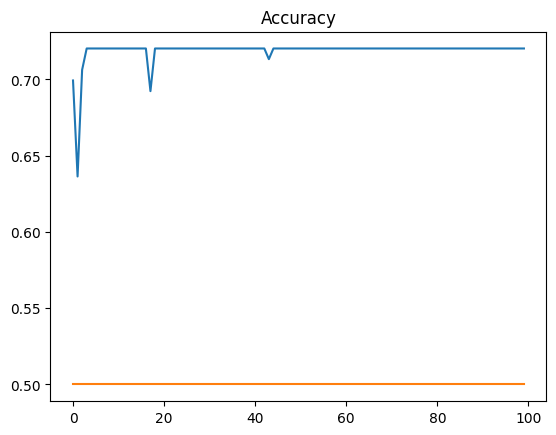

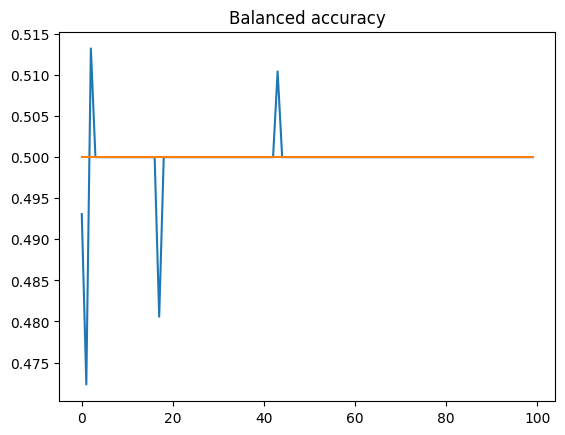

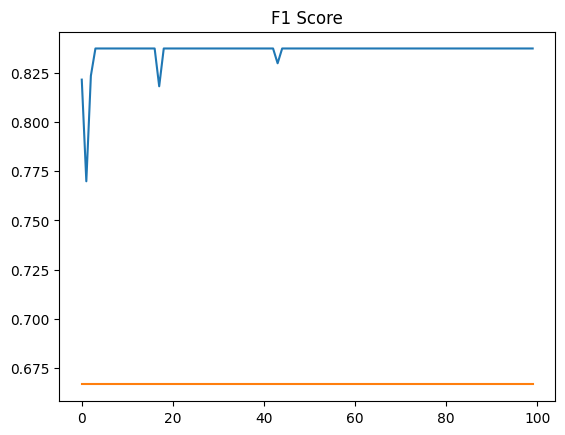

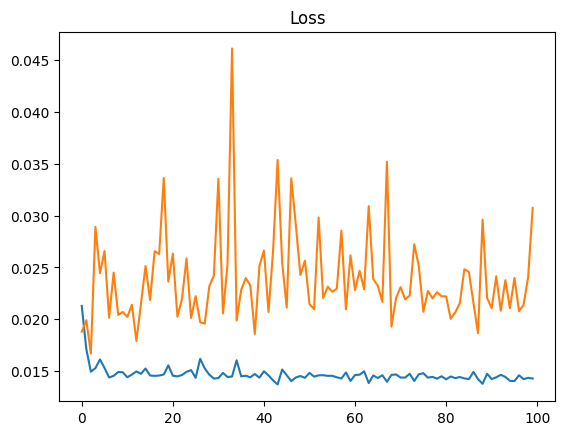

In [16]:
trainer(
    model,
    optimizer,
    criterion,
    train_dataloader,
    val_dataloader,
    n_epochs,
    device
)

In [17]:
all_ids, all_preds = predict(model, test_dataloader, device)
submission_df = pd.DataFrame({"ID": all_ids, "Predicted": all_preds})
submission_df.to_csv(os.path.join(save_dir, "submission_01.csv"), index=False)

[Epoch 1 / 100]
	train loss = 0.0282 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
	test loss = 0.0212 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 2 / 100]
	train loss = 0.0219 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
	test loss = 0.0183 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 3 / 100]
	train loss = 0.0191 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
	test loss = 0.0181 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 4 / 100]
	train loss = 0.0186 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
	test loss = 0.0184 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 5 / 100]
	train loss = 0.0186 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
	test loss = 0.0173 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 6 / 100]
	train loss = 0.0182 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
	test loss = 0.0179 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 7 / 100]
	train loss = 0.0184 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
	test loss = 0.0178 acc = 0.5000 bacc = 0.5000 f1 = 0.6667
[Epoch 8 / 100]
	train loss = 0.0181 acc = 0.5000 bacc 

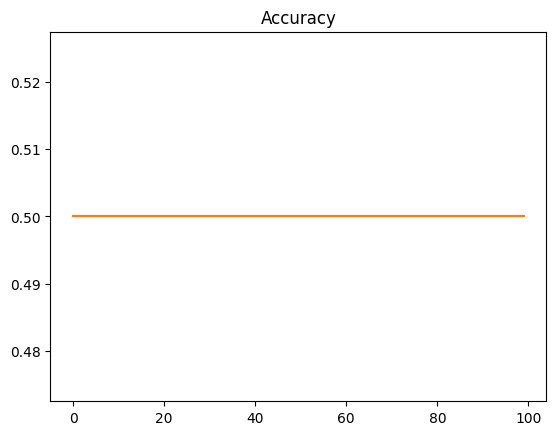

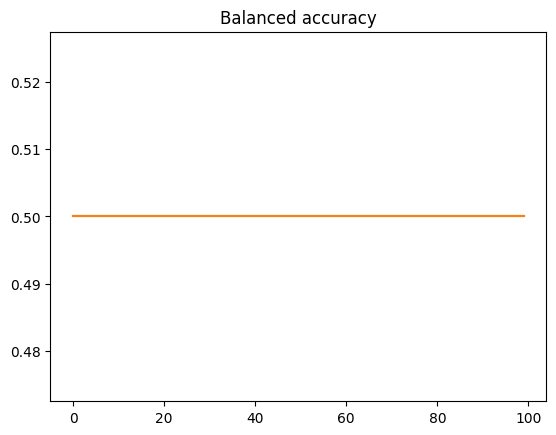

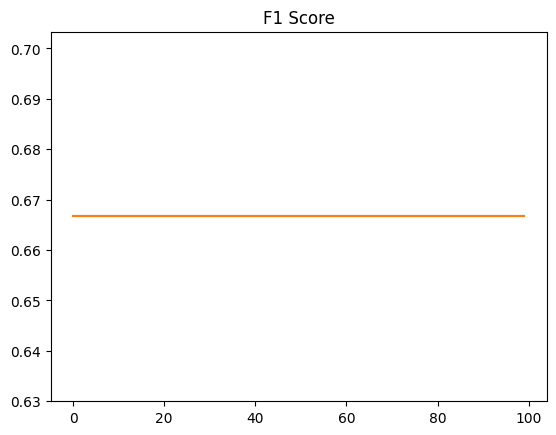

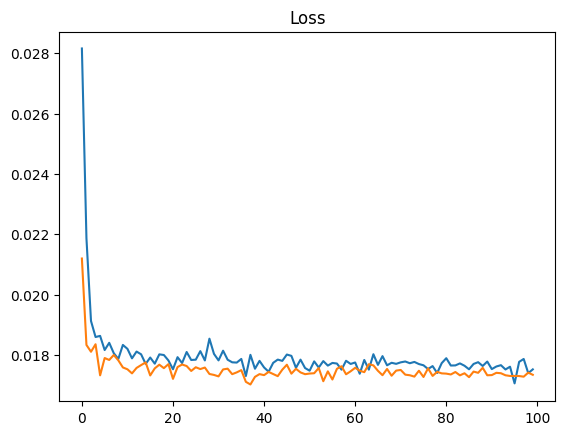

In [18]:
trainer(
    model,
    optimizer,
    criterion,
    val_dataloader,
    val_dataloader,
    n_epochs,
    device
)

In [19]:
all_ids, all_preds = predict(model, test_dataloader, device)
submission_df = pd.DataFrame({"ID": all_ids, "Predicted": all_preds})
submission_df.to_csv(os.path.join(save_dir, "submission_02.csv"), index=False)